# Image Stitching

This notebook looks into stitching images which is a common computer vision task. Before anything, we first setup our environment.

In [1]:
import os
import imutils
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

First, we load our train and query image.

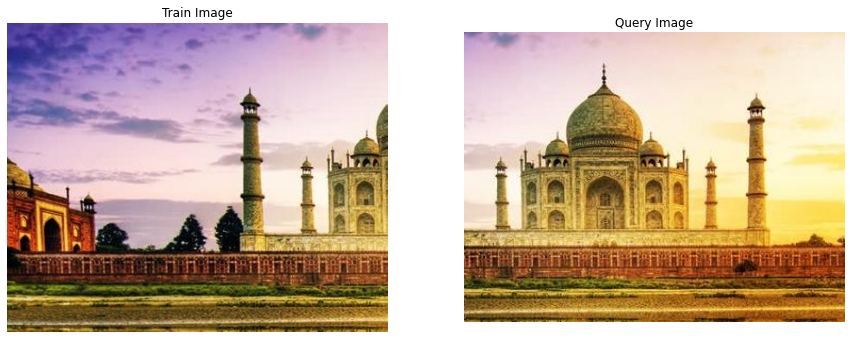

In [2]:
raw_train_image = cv.imread("/content/data/1a.jpg")
raw_train_image = cv.cvtColor(raw_train_image, cv.COLOR_BGR2RGB)
raw_query_image = cv.imread("/content/data/1b.jpg")
raw_query_image = cv.cvtColor(raw_query_image, cv.COLOR_BGR2RGB)

plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.title("Train Image")
plt.imshow(raw_train_image, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Query Image")
plt.imshow(raw_query_image, cmap="gray")
plt.axis("off")

plt.show()

Then, we want to extract keypoints and features from both images with Scale-invariant Feature Transform (SIFT). The image should then be converted to gray beforehand. With a gray image, we only extract relevant information needed for the experimentation and simplifies the calculation complexity.

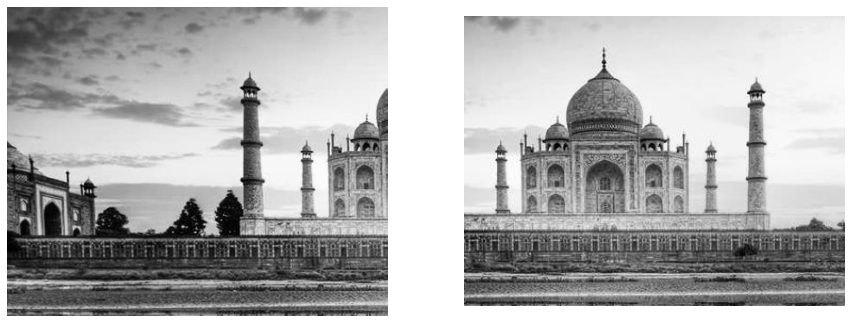

In [3]:
sift = cv.SIFT_create()
train_image = cv.cvtColor(raw_train_image, cv.COLOR_RGB2GRAY)
query_image = cv.cvtColor(raw_query_image, cv.COLOR_RGB2GRAY)
train_keypoints, train_descriptors = sift.detectAndCompute(train_image, None)
query_keypoints, query_descriptors = sift.detectAndCompute(query_image, None)

plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.imshow(train_image, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(query_image, cmap="gray")
plt.axis("off")

plt.show()

After obtaining keypoints and descriptors of both images, we want to also extract the matches with the flann based matcher implementing the k-Nearest Neighbors (kNN) and applying Lowe's ratio test to identify good matches.

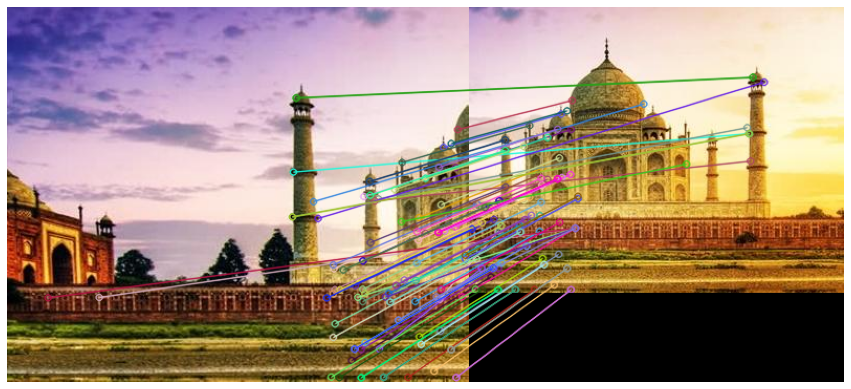

In [4]:
index_params = dict(algorithm=0, trees=5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(train_descriptors, query_descriptors, k=2)

good_matches = []
for m, n in matches:
  if m.distance < n.distance * 0.7:
    good_matches.append(m)

matches_image = cv.drawMatches(raw_train_image, 
                               train_keypoints, 
                               raw_query_image, 
                               query_keypoints, 
                               np.random.choice(good_matches, 100), 
                               None, 
                               flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15, 8))
plt.imshow(matches_image)
plt.axis("off")
plt.show()

There we have some of our good matches visualized, although there still exists some improper matches as we can see to the leftmost keypoints. After this, the idea is to stitch the image in a way that it produces a good resulting image. For that, we should compute the homography matrix which will help us map or transform an image onto the same plane as the other image before getting to stitch them.

In [5]:
train_pts = np.array([train_keypoints[m.queryIdx].pt for m in good_matches], dtype="float32").reshape((-1, 1, 2))
query_pts = np.array([query_keypoints[m.trainIdx].pt for m in good_matches], dtype="float32").reshape((-1, 1, 2))
homography, _ = cv.findHomography(train_pts, query_pts, cv.RANSAC, 5.0)
homography

array([[ 7.63574566e-01, -4.15408947e-04, -2.30140223e+02],
       [-3.66604343e-04,  7.63031421e-01,  1.38446228e-01],
       [ 1.97442687e-07, -1.73241195e-06,  1.00000000e+00]])

There we have the homography matrix which is a 3x3 matrix with 8 degrees of freedom.

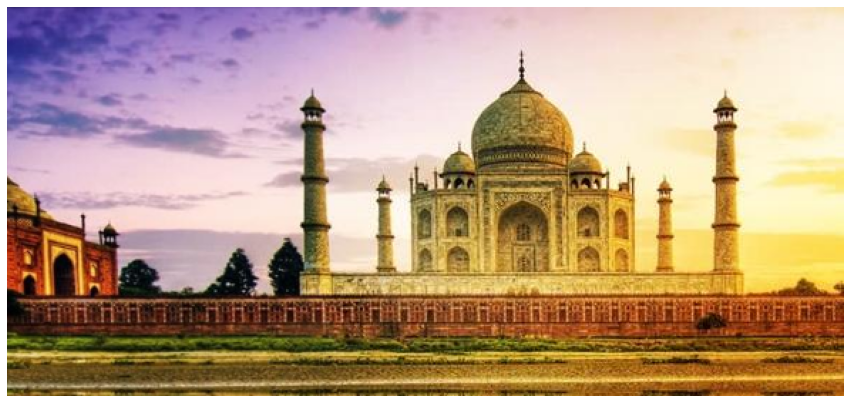

In [6]:
height = raw_query_image.shape[0]
width = raw_query_image.shape[1]

# Get canvas dimensions
train_pts = np.array([[0, height],
                      [width, height],
                      [width, 0]],
                     dtype='float32').reshape((-1, 1, 2))

# Compute relative perspective of the train image with previously obtained homography
transformed_pts = cv.perspectiveTransform(train_pts, homography)
# Get resulting dimensions
pts = np.concatenate((train_pts, transformed_pts), axis=0)

# Calculate match points dimensions to bring both images together
[x_min, y_min] = (pts.min(axis=0).ravel() - 0.5).astype('int32')
[x_max, y_max] = (pts.max(axis=0).ravel() + 0.5).astype('int32')

# Compute translation vector
translation_vector = np.array([[1, 0, -x_min],
                               [0, 1, -y_min],
                               [0, 0, 1]])

# Warp and overlap both images
stitched_image = cv.warpPerspective(raw_train_image,
                                    translation_vector.dot(homography),
                                    (x_max - x_min, y_max - y_min))

stitched_image[-y_min:height - y_min, -x_min:width - x_min] = raw_query_image

plt.figure(figsize=(15, 8))
plt.imshow(stitched_image)
plt.axis("off")
plt.show()

Now we have our train image and query image stitched, there is still an image left to stitched.

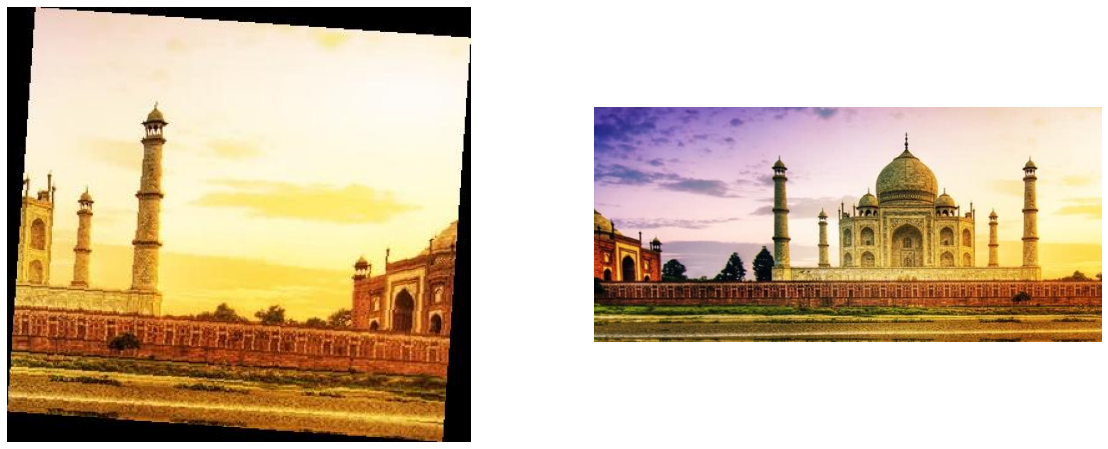

In [7]:
raw_train_image = cv.imread("/content/data/1c.jpg")
raw_train_image = cv.cvtColor(raw_train_image, cv.COLOR_BGR2RGB)
raw_query_image = stitched_image.copy()

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.imshow(raw_train_image, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(raw_query_image, cmap="gray")
plt.axis("off")

plt.show()

Again, we convert both images to grayscale and extract both keypoints and descriptors with Scale-Invariant Feature Transform (SIFT).

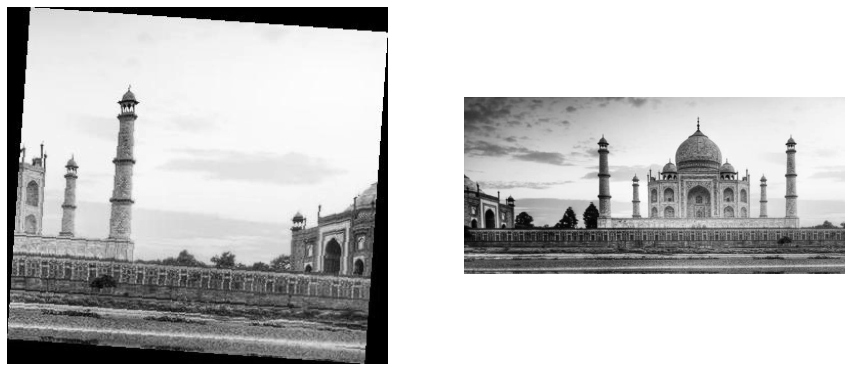

In [8]:
train_image = cv.cvtColor(raw_train_image, cv.COLOR_RGB2GRAY)
query_image = cv.cvtColor(raw_query_image, cv.COLOR_RGB2GRAY)
train_kp, train_desc = sift.detectAndCompute(train_image, None)
query_kp, query_desc = sift.detectAndCompute(query_image, None)

plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.imshow(train_image, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(query_image, cmap="gray")
plt.axis("off")

plt.show()

We simply use the same way to extract matches between both images with flann based matcher implementing the k-Nearest Neighbor and identify good matches with Lowe's ratio test.

In [9]:
index_params = dict(algorithm=0, trees=5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(train_desc, query_desc, k=2)

good_matches = []
for m, n in matches:
  if m.distance < n.distance * .7:
    good_matches.append(m)

To get the estimated translation between both images, we compute the homography implementing the RANSAC algorithm.

In [10]:
train_pts = np.array([train_kp[m.queryIdx].pt for m in good_matches], dtype='float32').reshape((-1, 1, 2))
query_pts = np.array([query_kp[m.trainIdx].pt for m in good_matches], dtype='float32').reshape((-1, 1, 2))
homography, _ = cv.findHomography(train_pts, query_pts, cv.RANSAC, 5.0)

homography

array([[ 8.30829794e-01,  5.20779836e-02,  4.00262620e+02],
       [-6.06887017e-02,  8.33457646e-01,  1.57330934e+00],
       [-7.93203453e-06, -1.25527877e-05,  1.00000000e+00]])

After obtaining the homography matrix, we can now look to stitching both images.

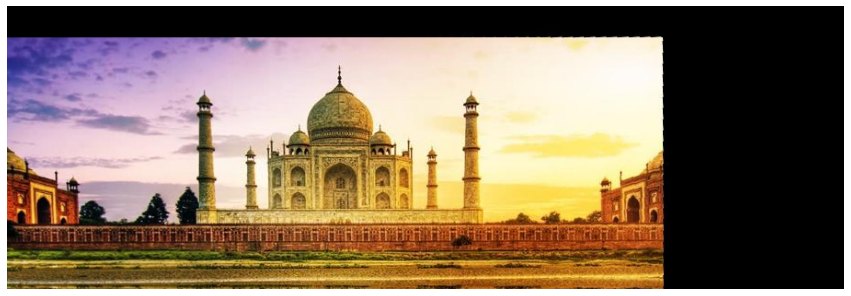

In [11]:
height = raw_query_image.shape[0]
width = raw_query_image.shape[1]

train_pts = np.array([[0, height],
                      [width, height],
                      [width, 0]],
                     dtype='float32').reshape((-1, 1, 2))

transformed_pts = cv.perspectiveTransform(train_pts, homography)
pts = np.concatenate((train_pts, transformed_pts), axis=0)

[x_min, y_min] = (pts.min(axis=0).ravel() - 0.5).astype('int32')
[x_max, y_max] = (pts.max(axis=0).ravel() + 0.5).astype('int32')

translation_vector = np.array([[1, 0, -x_min],
                               [0, 1, -y_min],
                               [0, 0, 1]])

stitched_image = cv.warpPerspective(raw_train_image,
                                    translation_vector.dot(homography),
                                    (x_max - x_min, y_max - y_min))

stitched_image[-y_min:height - y_min, -x_min:width - x_min] = raw_query_image

plt.figure(figsize=(15, 8))
plt.imshow(stitched_image)
plt.axis("off")
plt.show()

Although there are still a lot of contours on the image, overall the stitching went very well. The final task would be to remove all those contours to obtain a clean resulting image of our image stitching.

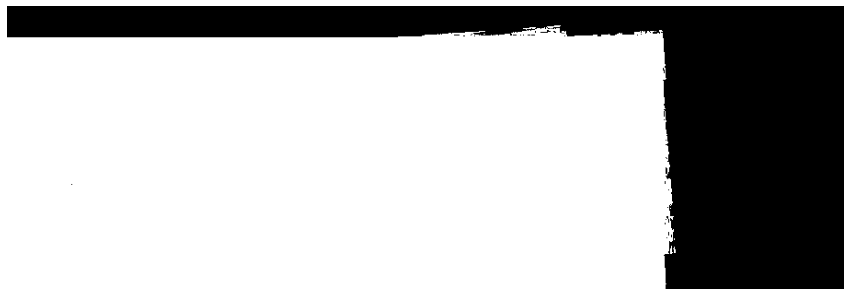

In [12]:
gray_image = cv.cvtColor(stitched_image, cv.COLOR_RGB2GRAY)
_, threshold = cv.threshold(gray_image, 0, 255, cv.THRESH_BINARY)

plt.figure(figsize=(15, 8))
plt.imshow(threshold, cmap="gray")
plt.axis("off")
plt.show()

After getting the threshold image, it is obvious that the transformation is not flawless. As we can see, the edges are not that clean on the right side.

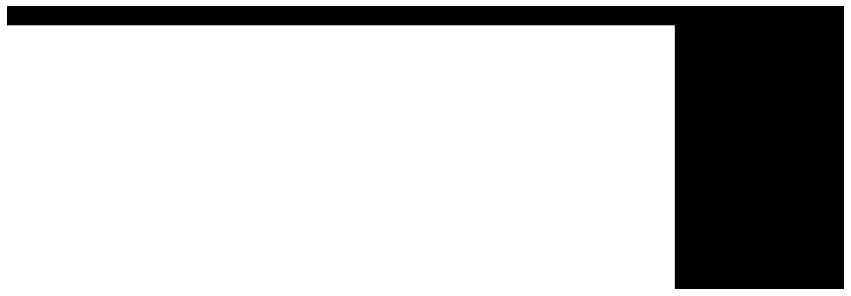

In [13]:
contours = cv.findContours(threshold.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
area = max(contours, key=cv.contourArea)
mask = np.zeros(threshold.shape, dtype="uint8")
x, y, w, h = cv.boundingRect(area)
cv.rectangle(mask, (x, y), (x + w, y + h), 255, -1)

plt.figure(figsize=(15, 8))
plt.imshow(mask, cmap="gray")
plt.axis("off")
plt.show()

The idea here is we try to mask out the contours so that we can use the mask dimensions to obtain a new image with less contours.

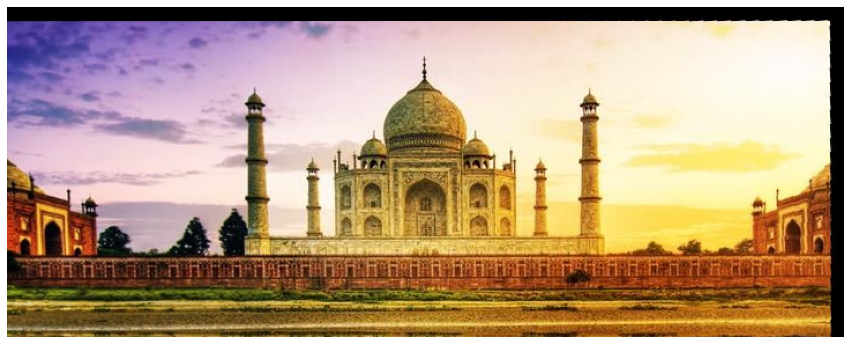

In [14]:
result_image = stitched_image[y:y + h, x: x + w]

plt.figure(figsize=(15, 8))
plt.imshow(result_image, cmap="gray")
plt.axis("off")
plt.show()

The resulting image seems all good except for the remaining contours. So far, we still had some issue figuring out how to prevent those noisy edges to appear in the first place. However, there is some improvements to be made within this notebook.